# Praca domowa 3
Michał Piasecki


# 1. ***Ablation Study***
Za tym pojęciem skrywa się idea usuwania poszczególnych części sieci neuronowej (lub ogólniej rzecz ujmując: pewnych składowych modelu AI), aby odkryć jakie mają one znaczenie dla funkcjonowania całego modelu. Taka analiza, pozwala nam usuwać części modelu, które są redundantne i jedynie spowalniają jego działanie. Dodatkowo możemy "zbliżać się" do rozumienia co robią poszczególne składowe, co w konsekwencji może prowadzić do rozumienia na wyższym poziomie dlaczego naszym modelom udaje się osiągać w konkretnych zadaniach dobre rezultaty.



Plan działania: \\
Poniżej, pobierzemy popularny pakiet CIFAR-10 zawierający zbiór obrazków należących do 10 kategorii (samoloty, psy, ptaszki, itd.) i zbudujemy model, który będzie klasyfikował do której kategorii należy każdy obrazek.
Następnie pousuwamy różne składowe modelu aby spróbować zrozumieć ich działanie.



# Pakieciki

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(2020) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from numpy.random import seed
seed(12)


# Dodatkowe funkcje

In [ ]:
def plotting_model(model_info):
  table = pd.DataFrame.from_dict(model_info.history)
  table.reset_index(inplace = True)
  plt.figure(figsize = (20,10))
  plt.plot(table['index'],table['accuracy'], color = 'skyblue', label = 'accuracy')
  plt.plot(table['index'],table['val_accuracy'], color = 'orange', label = 'test accuracy')
  plt.grid(alpha = 0.2)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(prop={'size': 20})
  plt.show()


def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [ ]:
def calosc_ladniutko(model, train_features, train_labels, test_features,test_labels):
  start = time.time()
  model_info = model.fit(x = train_features, y = train_labels,batch_size = 64,validation_data = (test_features, test_labels), steps_per_epoch= 100, epochs= 200, verbose = 0)
  end = time.time()
  print ("Dokładność modelu: %0.2f"%accuracy(test_features, test_labels, model))
  print(f'Czas wykonywania: {round((end - start),2)} sekund, czyli {round((end - start) / 60,2)} minut')
  plotting_model(model_info)



# Dane

In [ ]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test  =  test_features.shape[0]
num_classes = len(np.unique(train_labels))



# Jak wyglądają nasze obrazki

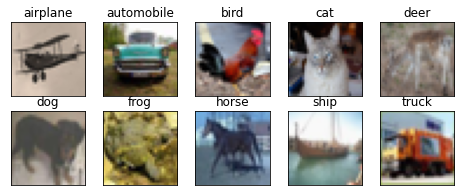

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

# Data processing

In [ ]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Budujemy model

In [ ]:
model_basic = Sequential()
model_basic.add(Convolution2D(48, (3, 3),activation='relu', input_shape=(32, 32,3)))
model_basic.add(MaxPooling2D((2, 2)))
model_basic.add(Dropout(0.25))
model_basic.add(Convolution2D(96, (3, 3),activation='relu'))
model_basic.add(MaxPooling2D((2, 2)))
model_basic.add(Dropout(0.25))
model_basic.add(Convolution2D(192, (3, 3),activation='relu'))
model_basic.add(MaxPooling2D((2, 2)))
model_basic.add(Dropout(0.25))
model_basic.add(Flatten())
model_basic.add(Dense(512, activation = 'relu'))
model_basic.add(Dropout(0.5))
model_basic.add(Dense(256,activation = 'relu'))
model_basic.add(Dropout(0.5))
model_basic.add(Dense(num_classes, activation='softmax'))
model_basic.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Dokładność modelu: 76.59
Czas wykonywania: 313.55 sekund, czyli 5.23 minut


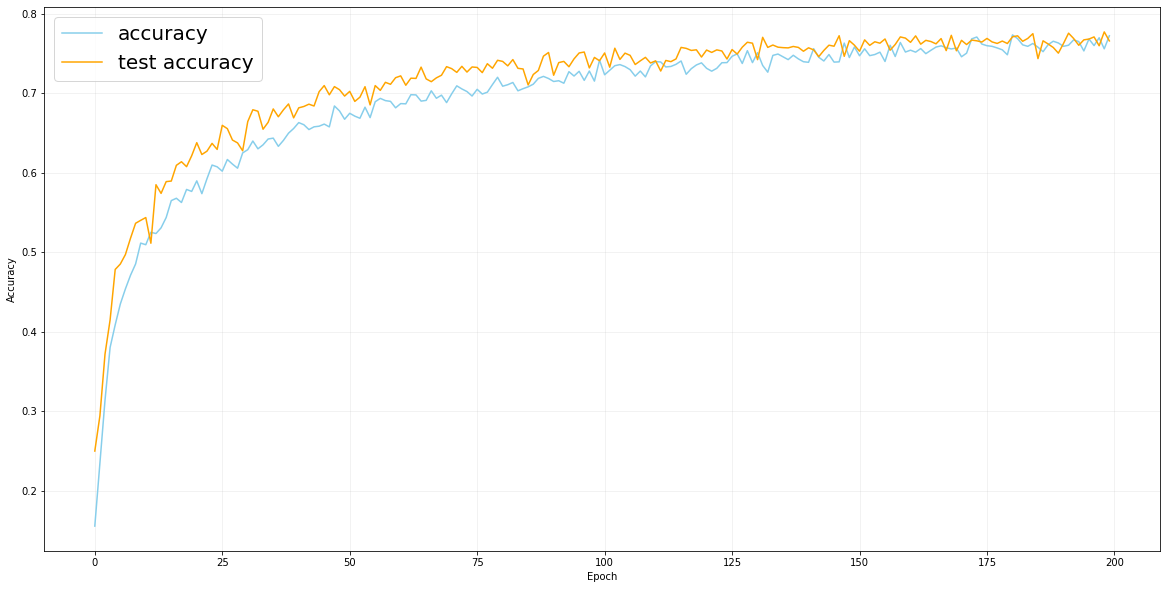

In [ ]:
calosc_ladniutko(model_basic, train_features, train_labels, test_features,test_labels)

# Pierwsze rezultaty
Okej, odpaliliśmy nasz model i osiągneliśmy jakieś rezultaty. Po 200 epokach nasz model osiągnął accuracy na poziomie 77 procent. Widzimy, że nie ma praktycznie żadnej różnicy pomiędzy wynikiem na zbiorze testowym i treninowym. Całość zajęła nam 5 minut. Widzimy też, że właściwie po 100 epoce nasz model bardzo wyhamował w uczeniu się.

# Eksperymetujemy

## 1 Warstwy Dropout
Wartwy Dropout w naszym modelu ustawia jakąś część wartości (regulowaną przez parametr rate) na 0, a pozostałe przemnaża przez 1/(1 - rate), aby suma wartości wejściowych i wyjściowych była taka sama. Dzięki Dropoutowi unikamy overfittingu. Usuńmy warstwy Dropoutu i zobaczmy, czy rzeczywiście tak jest.

In [ ]:
model = Sequential()
model.add(Convolution2D(48, (3, 3),activation='relu', input_shape=(32, 32,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Convolution2D(96, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Convolution2D(192, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 30, 30, 48)        1344      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 15, 15, 48)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 13, 13, 96)        41568     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 6, 6, 96)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 192)         166080    
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 2, 2, 192)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 768)              

Dokładność modelu: 72.86
Czas wykonywania: 298.71 sekund, czyli 4.98 minut


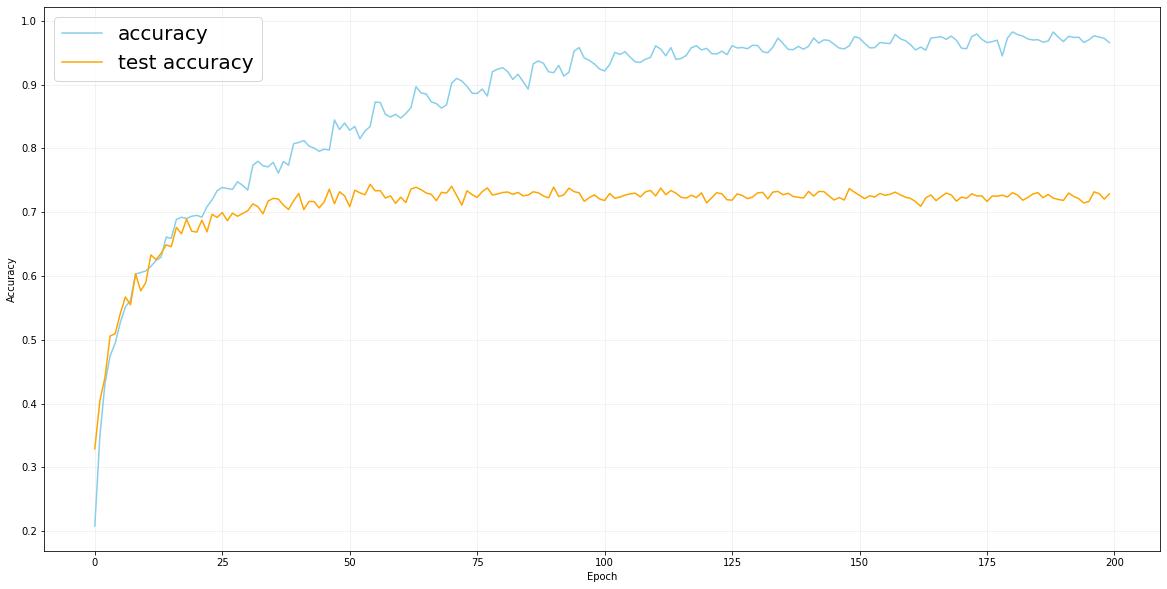

In [ ]:
calosc_ladniutko(model, train_features, train_labels, test_features,test_labels)

Rzeczywiście widzimy, że warstwy Dropout chronią nasz model przed overfittingiem. W przypadku modelu, w którym je usuwamy różnica pomiędzy accuracy na zbiorze treningowym, a testowym wynosi niecałe 20 punktów procentowych!
Widzimy, że pomimo tego, że na zbiorze treningowym osiągnęliśmy lepszy rezultat od wyjściowego modelu (95 procent w porównaniu do 78), to na zbiorze testowym, już radzi sobie d gorzej osiągając 72 procent. Czas wykonywania modelu zmniejszył się nieznacznie



# 2 Max Pooling
Poeksperymentujmy z Max Poolingiem. Niech oblicza wartości z większych kwadratów, np. 4x4. To co powinniśmy na pewno osiągnąć to skrócony czas całego modelu. Musimy też usunąć trzecią parę (conv2d, maxpooling), bo już zeszliśmy rozmiarem do 1.

In [ ]:
model = Sequential()
model.add(Convolution2D(48, (3, 3),activation='relu', input_shape=(32, 32,3)))
model.add(MaxPooling2D((4, 4)))
model.add(Dropout(0.25))
model.add(Convolution2D(96, (3, 3),activation='relu'))
model.add(MaxPooling2D((4, 4)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Dokładność modelu: 63.56
Czas wykonywania: 206.67 sekund, czyli 3.44 minut


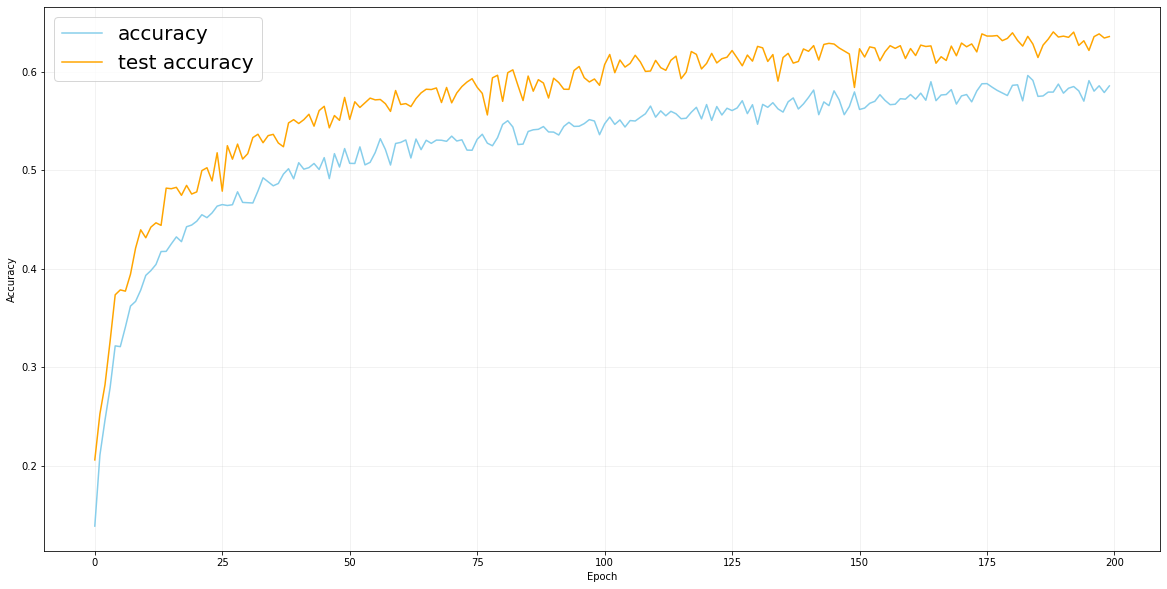

In [ ]:
calosc_ladniutko(model, train_features, train_labels, test_features,test_labels)

Widzimy, że rzeczywiście nasz model wykonał się krócej, ale ucierpiała na tym jego accuracy, która wynosi jedynie 64 %.

## 3 Usunięcie jednej warstwy Dense
Zobaczmny co się stanie kiedy pomniemy środkowo warstwę Dense

In [ ]:
model = Sequential()
model.add(Convolution2D(48, (3, 3),activation='relu', input_shape=(32, 32,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(96, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(192, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Dokładność modelu: 77.96
Czas wykonywania: 306.14 sekund, czyli 5.1 minut


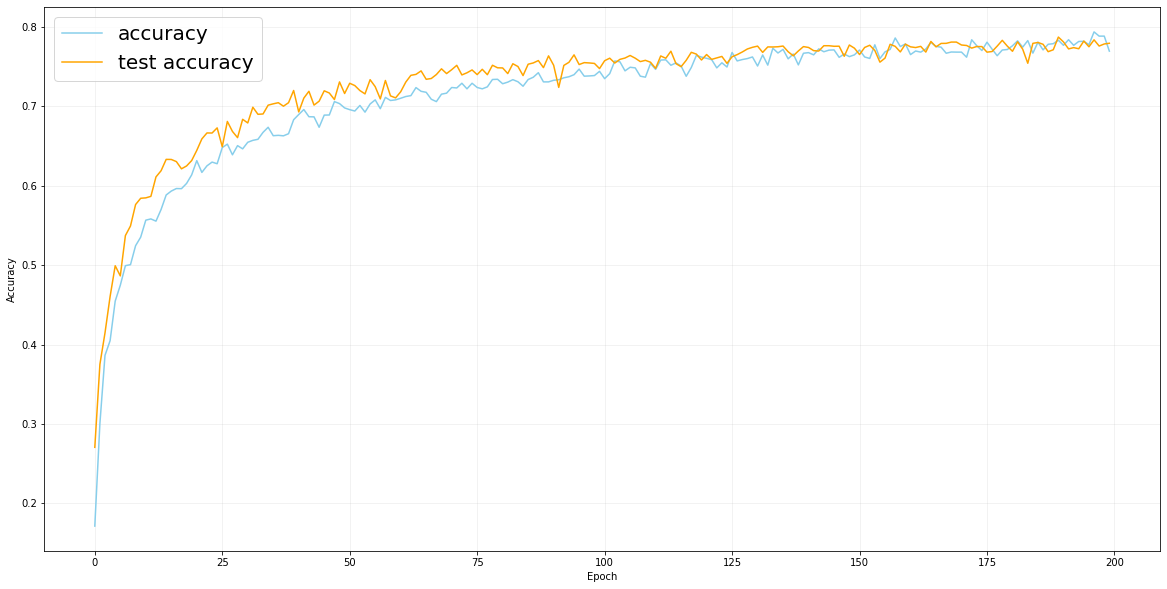

In [ ]:
calosc_ladniutko(model, train_features, train_labels, test_features,test_labels)

Właściwie to nasz model się lekko poprawił :o. Wychodzi na to, że ta warstwa nie tylko była zbędna, ale wręcz szkodliwa, chociaż nie wiadomo jak by wyglądała róznica przy większej ilości epok. przynajmniej ja tego nie wiem :(   

## 4 Zmiana funkcji aktywacji
Zmieńmy naszą funkcję aktywacji na funkcję eksponencjalną i zobaczmy jakie to będzie miało konsekwencje.

In [ ]:
model = Sequential()
model.add(Convolution2D(48, (3, 3),activation='exponential', input_shape=(32, 32,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(96, (3, 3),activation='exponential'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(192, (3, 3),activation='exponential'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation = 'exponential'))
model.add(Dropout(0.5))
model.add(Dense(256,activation = 'exponential'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Dokładność modelu: 10.00
Czas wykonywania: 323.91 sekund, czyli 5.4 minut


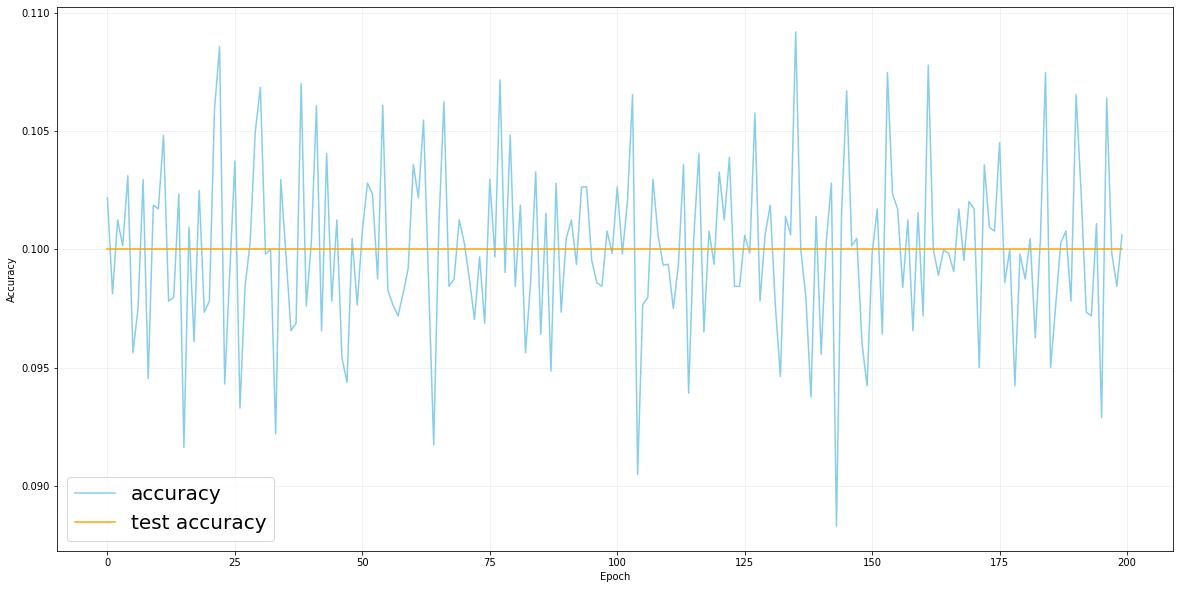

In [ ]:
calosc_ladniutko(model, train_features, train_labels, test_features,test_labels)

No  fatalnie sobie poradził.

To już wszystko :)
